In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

In [2]:
with sqlite3.connect('logs/logs.db') as conn:
    logs = pd.read_sql(
    """
    SELECT * FROM logs
    WHERE datetime BETWEEN '2018-01-01' AND '2019-01-01'
    """,
        conn, parse_dates=['datetime'], index_col='datetime'
    )

In [3]:
logs.head()

,source_ip,username,success,failure_reason
datetime,,,,
2018-01-01 00:06:19.353126,223.178.55.3,djones,1,None
2018-01-01 00:09:07.147971,223.178.55.3,djones,1,None
2018-01-01 01:08:08.610041,6.252.142.27,asmith,1,None
2018-01-01 02:37:50.329298,124.178.25.98,akim,1,None
2018-01-01 02:45:20.382080,98.43.141.103,akim,1,None


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43283 entries, 2018-01-01 00:06:19.353126 to 2018-12-31 23:24:52.807237
Data columns (total 4 columns):
source_ip         43283 non-null object
username          43283 non-null object
success           43283 non-null int64
failure_reason    19127 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
logs.groupby('source_ip').agg(dict(username='nunique')).describe()

,username
count,11559.000000
mean,1.175275
std,2.726389
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,135.000000


In [6]:
pivot = pd.pivot_table(
    logs, values='success', index=logs.source_ip, aggfunc='count',
    columns=logs.failure_reason.fillna('success'), fill_value=0
)
pivot.insert(0, 'attempts', pivot.sum(axis=1))
pivot = pivot.sort_values(by='attempts',ascending=False).assign(
        success_rate= lambda x: x.success/x.attempts,
        error_rate= lambda x: 1- x.success_rate
)
pivot.head()

failure_reason,attempts,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,
78.174.30.56,248,67,141,40,0.161290,0.838710
228.144.254.255,243,71,130,42,0.172840,0.827160
215.189.60.53,211,75,106,30,0.142180,0.857820
158.11.94.79,210,2,0,208,0.990476,0.009524
226.227.77.216,193,1,0,192,0.994819,0.005181


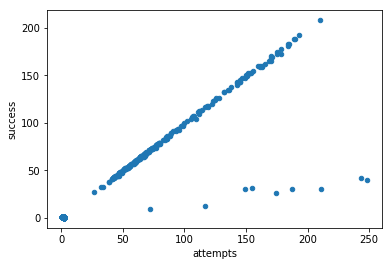

In [7]:
pivot.plot(
    kind='scatter', x='attempts', y='success'
)

In [8]:
logs = logs.assign(
    failures = lambda x: 1- x.success
)

In [13]:
failures = logs['2018'].query('failures > 0').groupby('source_ip').resample('1min'
    ).agg({'username':'nunique', 'failures':'sum'}).dropna()

MemoryError: 

In [10]:
failures

,,username,failures
source_ip,datetime,,
1.104.99.106,2018-12-29 03:28:00,1,2
1.113.134.70,2018-12-19 21:45:00,1,1
1.118.111.205,2018-12-12 13:21:00,2,2
1.135.101.60,2018-11-11 14:23:00,1,1
1.141.171.111,2018-12-18 10:38:00,1,2
